# Example: word classification with multiple spectrogram
Experimental notebook by @ste

TL;DR

The current dataset has a lot of short words and some long words.
If you look at the samples of "single spectrogram" notebook you'll see that for short sounds almost all the resulting spectrogram is "silence".

So I've tried to create a sample notebook that, instead of a single channel, transform the "augmented" sound (volume, noise, ...) into a three channel image where:
 - channel 0: is the complete spectrogram (like single spectrogram notebook)
 - channel 1: contains a spectrogram created with the first 50% of the sound (for medium lenght sounds)
 - channel 2: is the spectrogram for short sound 
 
**With the single spectrogram approach (using 10% of train/valid) I've got 29% accouracy, with multi spectrogram approach I've got 37%.**

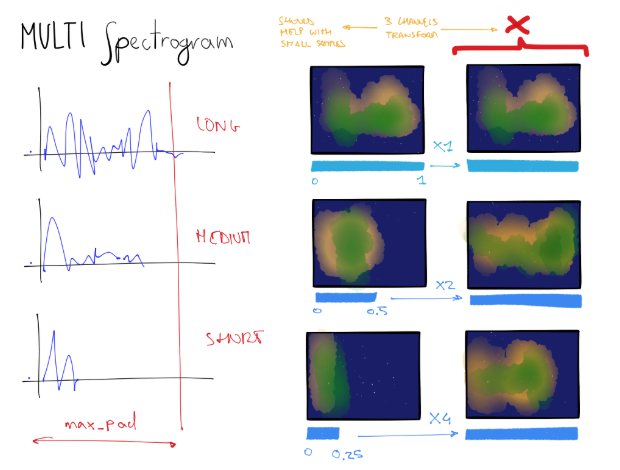

The key point is understanding the "chain of transformations" that takes the original data (a "sound") and converts them it into an suitable input for the model.
This chain comprises two main parts:
* DATA AUGMENTATION: f(sound) -> sound 
* STRUCTURE TRANSFORM: f(sound) -> tensor

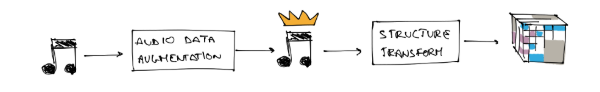

NB: theese images are part of a coming post on that matter... 

In [1]:
## Notebook settings
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
## fastai imports
from fastai.basics import *
from fastai.data_block import ItemList
from fastai.vision import *

Import FastAI Audio modules here:

In [3]:
from exp.nb_AudioCommon import *
from exp.nb_DataBlock import *
from exp.nb_DataAugmentation import *
from exp.nb_AudioTransformsManager import *

### Other library imports

If this cell fails, you probably haven't installed the correct system/Python dependencies. You might need to re-run the "System setup" cell again.

In [4]:
import torch
from pdb import set_trace
from IPython.display import Audio
from pydub import AudioSegment, silence
import torchaudio
from torchaudio import transforms
import pandas as pd

In [5]:
#Options
pd.set_option('display.max_colwidth', -1)

## Preparing the data

We're going to do **phoneme classification** using the TIMIT dataset.

The copyright on TIMIT isn't clear, and the data is hard to download, so we assume that the user has access to this dataset.

**IMPORTANT:** the dataset should be located in the standard fast.ai location:
> $HOME/.fastai/data/timit

In [6]:
#Fast.ai way to get folder for your dataset
path = datapath4file('timit')

### Parsing the data

In [7]:
def extractInformationsFromAbsolutePath(s: str):
    items = list(filter(lambda x: len(x)>0,s.split('/')))
    USAGE = items[0]
    DIALECT = items[1]
    SEX = items[2][0]
    SPEAKER_ID = items[2][1:]
    SENTENCE_ID = items[3]
    return USAGE, DIALECT, SEX, SPEAKER_ID, SENTENCE_ID
    
def test_extractInformationsFromAbsolutePath():
    USAGE, DIALECT, SEX, SPEAKER_ID, SENTENCE_ID = extractInformationsFromAbsolutePath('/TRAIN/DR7/MPAR0/SI2206')
    assert 'TRAIN'==USAGE
    assert 'DR7'==DIALECT
    assert 'M'==SEX
    assert 'PAR0'==SPEAKER_ID
    assert 'SI2206'==SENTENCE_ID
    print('TEST PASED')

test_extractInformationsFromAbsolutePath()

TEST PASED


In [8]:
def extractTimitDatasetInformation(path):
    '''Put in a dataframe all the information about samples'''
    import glob
    files = glob.glob(str(path)+ '/**/*.WAV', recursive=True)
    ret = pd.DataFrame(files, columns=['relPath'])
    #Remove path and extension
    ret['relPath'] = ret['relPath'].apply(lambda x: x.replace(str(path),'').replace('.WAV',''))

    def extractIntoSeries(s):
        USAGE, DIALECT, SEX, SPEAKER_ID, SENTENCE_ID = extractInformationsFromAbsolutePath(s)
        return pd.Series({
            'USAGE': USAGE,
            'DIALECT': DIALECT,
            'SEX': SEX,
            'SPEAKER_ID': SPEAKER_ID,
            'SENTENCE_ID': SENTENCE_ID,
            'IDX': SEX + SPEAKER_ID + ':' + SENTENCE_ID})

    #IMPORTANT: Apply multiple transformations at one
    ret = ret.merge(ret['relPath'].apply(lambda s: extractIntoSeries(s)), left_index=True, right_index=True)    
    ret = ret.set_index(['IDX']) # Add index
    return ret
                
all_files_df = extractTimitDatasetInformation(path)
all_files_df.head()

,relPath,USAGE,DIALECT,SEX,SPEAKER_ID,SENTENCE_ID
IDX,,,,,,
MPAR0:SI2206,/TRAIN/DR7/MPAR0/SI2206,TRAIN,DR7,M,PAR0,SI2206
MPAR0:SX316,/TRAIN/DR7/MPAR0/SX316,TRAIN,DR7,M,PAR0,SX316
MPAR0:SI1576,/TRAIN/DR7/MPAR0/SI1576,TRAIN,DR7,M,PAR0,SI1576
MPAR0:SA1,/TRAIN/DR7/MPAR0/SA1,TRAIN,DR7,M,PAR0,SA1
MPAR0:SX46,/TRAIN/DR7/MPAR0/SX46,TRAIN,DR7,M,PAR0,SX46


In [9]:
print(f'Number of files: {len(all_files_df)}')

Number of files: 6300


### OPTIONAL Decimate dataset
To speedup computation we reduce train/valid set.

In [10]:
#DON'T RUN THIS CELL IN YOU WANT TOI USE ALL DATA
def decimate(train_df:pd.DataFrame, valid_df:pd.DataFrame, pct=.1)->pd.DataFrame:
    t1=train_df.sample(frac=pct, random_state=1)
    t2=valid_df.sample(frac=pct, random_state=1)
    return pd.concat([t1,t2],axis=0)

all_files_df=decimate(all_files_df[all_files_df.USAGE=='TRAIN'],all_files_df[all_files_df.USAGE=='TEST'],.1)
all_files_df.groupby(['USAGE'])['relPath'].count()

USAGE
TEST     168
TRAIN    462
Name: relPath, dtype: int64

# Word classification

## Create data bunch

In [11]:
def process_phn_file(idx:str, phn_file, sig, sr, ext, delimiter=' ')->pd.DataFrame:
    df = pd.read_csv(phn_file, delimiter=delimiter, header=None)
    df.columns = ['START', 'END', ext]
    df['SIG'] = df.apply(lambda x : sig[x['START']: x['END']], axis=1)
    df['SR'] = sr
    df['IDX'] = idx
    df['IDXN'] = pd.Series(map(lambda x: idx+':'+str(x), range(len(df))))   
    df = df.set_index(['IDXN'])
    return df

In [12]:
def extractItems(path, idx, relativePath, ext, verbose=False)->pd.DataFrame:
    base_path = str(path) + relativePath
    wav_file = base_path + ".WAV"
    wav_exists = os.path.isfile(wav_file)
    if verbose: print(wav_file, f'\tExists: {wav_exists}')
    #Sanity check
    if not wav_exists: return none
    #Proceed
    sigTwoChannels,sr = torchaudio.load(wav_file)
    sig = sigTwoChannels[0] # MONO NO STEREO - convert to "one dimension"
    phn_file = base_path + '.' + ext
            
    ret = process_phn_file(idx, phn_file, sig, sr, ext, delimiter=' ')
    
    return ret

#    sig,sr = torchaudio.load(str(phn_file.replace('PHN', 'WAV')))
#    df = process_phn_file(phn_file, sig, sr, delimiter=' ')
#    df['Source'] = phn_file
#    final = final.append(df)
            
def test_extractItems_PHN():
    row = all_files_df.iloc[0]
    ret_df = extractItems(path, row.name, row['relPath'], 'PHN', verbose=True)
    display(ret_df.head(2))
    print(f'Number of rows: {len(ret_df)}')
#    assert 54==len(ret_df)
    print('TEST DONE')

test_extractItems_PHN()

/home/ste/.fastai/data/timit/TRAIN/DR2/MJMD0/SX308.WAV 	Exists: True


,START,END,PHN,SIG,SR,IDX
IDXN,,,,,,
MJMD0:SX308:0,0,2320,h#,"[tensor(0.0001), tensor(0.0002), tensor(-3.0518e-05), tensor(6.1035e-05), tensor(-3.0518e-05), tensor(6.1035e-05), tensor(9.1553e-05), tensor(0.0001), tensor(0.0001), tensor(3.0518e-05), tensor(9.1553e-05), tensor(0.), tensor(-3.0518e-05), tensor(-9.1553e-05), tensor(0.0002), tensor(0.0001), tensor(0.0002), tensor(9.1553e-05), tensor(6.1035e-05), tensor(9.1553e-05), tensor(0.), tensor(0.0002), tensor(9.1553e-05), tensor(0.0001), tensor(0.0002), tensor(0.0002), tensor(0.0002), tensor(0.0002), tensor(0.0001), tensor(6.1035e-05), tensor(9.1553e-05), tensor(-9.1553e-05), tensor(3.0518e-05), tensor(0.0002), tensor(0.0002), tensor(0.0002), tensor(6.1035e-05), tensor(0.0002), tensor(0.), tensor(0.0001), tensor(9.1553e-05), tensor(0.0002), tensor(0.0002), tensor(0.0002), tensor(0.0001), tensor(0.0002), tensor(6.1035e-05), tensor(9.1553e-05), tensor(6.1035e-05), tensor(6.1035e-05), tensor(0.0002), tensor(0.), tensor(0.0002), tensor(0.0002), tensor(0.0002), tensor(9.1553e-05), tensor(9.1553e-05), tensor(9.1553e-05), tensor(0.0001), tensor(0.0001), tensor(0.0002), tensor(0.0002), tensor(0.0001), tensor(9.1553e-05), tensor(3.0518e-05), tensor(9.1553e-05), tensor(-6.1035e-05), tensor(-6.1035e-05), tensor(6.1035e-05), tensor(0.0001), tensor(3.0518e-05), tensor(3.0518e-05), tensor(6.1035e-05), tensor(3.0518e-05), tensor(-6.1035e-05), tensor(-3.0518e-05), tensor(3.0518e-05), tensor(0.0001), tensor(-3.0518e-05), tensor(0.0001), tensor(3.0518e-05), tensor(0.0001), tensor(0.), tensor(3.0518e-05), tensor(0.), tensor(0.), tensor(9.1553e-05), tensor(9.1553e-05), tensor(0.0001), tensor(0.0002), tensor(9.1553e-05), tensor(3.0518e-05), tensor(0.0002), tensor(0.), tensor(9.1553e-05), tensor(9.1553e-05), tensor(0.0001), tensor(0.0002), tensor(0.0001), tensor(9.1553e-05), ...]",16000,MJMD0:SX308
MJMD0:SX308:1,2320,4803,sh,"[tensor(3.0518e-05), tensor(-0.0002), tensor(-3.0518e-05), tensor(0.0004), tensor(0.0003), tensor(0.0002), tensor(-0.0002), tensor(6.1035e-05), tensor(0.0002), tensor(0.0002), tensor(9.1553e-05), tensor(-0.0004), tensor(0.0002), tensor(0.0006), tensor(0.), tensor(-0.0002), tensor(-6.1035e-05), tensor(9.1553e-05), tensor(0.0003), tensor(0.0003), tensor(0.0002), tensor(-0.0005), tensor(-0.0005), tensor(0.0001), tensor(0.0003), tensor(0.0005), tensor(0.0005), tensor(-0.0007), tensor(-0.0005), tensor(0.0007), tensor(0.0005), tensor(-0.0002), tensor(-0.0002), tensor(0.0003), tensor(-0.0001), tensor(-0.0005), tensor(0.0005), tensor(0.0006), tensor(-0.0004), tensor(-0.0003), tensor(-3.0518e-05), tensor(-0.0002), tensor(0.0007), tensor(0.0005), tensor(-0.0007), tensor(-0.0006), tensor(-0.0002), tensor(0.0005), tensor(0.0008), tensor(-0.0002), tensor(-0.0008), tensor(-9.1553e-05), tensor(0.0006), tensor(0.0006), tensor(0.0002), tensor(-0.0003), tensor(-3.0518e-05), tensor(6.1035e-05), tensor(-0.0005), tensor(-0.0003), tensor(3.0518e-05), tensor(-0.0004), tensor(-0.0005), tensor(-6.1035e-05), tensor(9.1553e-05), tensor(0.0003), tensor(0.0006), tensor(-0.0005), tensor(-0.0005), tensor(0.), tensor(-0.0002), tensor(0.0004), tensor(0.0005), tensor(-0.0003), tensor(-0.0003), tensor(0.0003), tensor(0.0006), tensor(0.0005), tensor(-0.0002), tensor(-0.0005), tensor(-3.0518e-05), tensor(-3.0518e-05), tensor(0.0005), tensor(-0.0004), tensor(-0.0005), tensor(0.0002), tensor(0.0002), tensor(0.0006), tensor(0.0003), tensor(-0.0004), tensor(-0.0003), tensor(0.0003), tensor(0.0004), tensor(0.0001), tensor(-0.0011), tensor(-0.0003), tensor(0.0006), tensor(0.0005), tensor(0.0009), tensor(0.0004), ...]",16000,MJMD0:SX308


Number of rows: 34
TEST DONE


In [13]:
def test_extractItems_WRD():
    row = all_files_df.iloc[0]
    ret_df = extractItems(path, row.name, row['relPath'], 'WRD', verbose=True)
    display(ret_df.head(1))
    print(f'Number of rows: {len(ret_df)}')
#    assert 14==len(ret_df)
    print('TEST DONE')

test_extractItems_WRD()

/home/ste/.fastai/data/timit/TRAIN/DR2/MJMD0/SX308.WAV 	Exists: True


,START,END,WRD,SIG,SR,IDX
IDXN,,,,,,
MJMD0:SX308:0,2320,11400,shipbuilding,"[tensor(3.0518e-05), tensor(-0.0002), tensor(-3.0518e-05), tensor(0.0004), tensor(0.0003), tensor(0.0002), tensor(-0.0002), tensor(6.1035e-05), tensor(0.0002), tensor(0.0002), tensor(9.1553e-05), tensor(-0.0004), tensor(0.0002), tensor(0.0006), tensor(0.), tensor(-0.0002), tensor(-6.1035e-05), tensor(9.1553e-05), tensor(0.0003), tensor(0.0003), tensor(0.0002), tensor(-0.0005), tensor(-0.0005), tensor(0.0001), tensor(0.0003), tensor(0.0005), tensor(0.0005), tensor(-0.0007), tensor(-0.0005), tensor(0.0007), tensor(0.0005), tensor(-0.0002), tensor(-0.0002), tensor(0.0003), tensor(-0.0001), tensor(-0.0005), tensor(0.0005), tensor(0.0006), tensor(-0.0004), tensor(-0.0003), tensor(-3.0518e-05), tensor(-0.0002), tensor(0.0007), tensor(0.0005), tensor(-0.0007), tensor(-0.0006), tensor(-0.0002), tensor(0.0005), tensor(0.0008), tensor(-0.0002), tensor(-0.0008), tensor(-9.1553e-05), tensor(0.0006), tensor(0.0006), tensor(0.0002), tensor(-0.0003), tensor(-3.0518e-05), tensor(6.1035e-05), tensor(-0.0005), tensor(-0.0003), tensor(3.0518e-05), tensor(-0.0004), tensor(-0.0005), tensor(-6.1035e-05), tensor(9.1553e-05), tensor(0.0003), tensor(0.0006), tensor(-0.0005), tensor(-0.0005), tensor(0.), tensor(-0.0002), tensor(0.0004), tensor(0.0005), tensor(-0.0003), tensor(-0.0003), tensor(0.0003), tensor(0.0006), tensor(0.0005), tensor(-0.0002), tensor(-0.0005), tensor(-3.0518e-05), tensor(-3.0518e-05), tensor(0.0005), tensor(-0.0004), tensor(-0.0005), tensor(0.0002), tensor(0.0002), tensor(0.0006), tensor(0.0003), tensor(-0.0004), tensor(-0.0003), tensor(0.0003), tensor(0.0004), tensor(0.0001), tensor(-0.0011), tensor(-0.0003), tensor(0.0006), tensor(0.0005), tensor(0.0009), tensor(0.0004), ...]",16000,MJMD0:SX308


Number of rows: 6
TEST DONE


In [14]:
all_files_df.head(2)

,relPath,USAGE,DIALECT,SEX,SPEAKER_ID,SENTENCE_ID
IDX,,,,,,
MJMD0:SX308,/TRAIN/DR2/MJMD0/SX308,TRAIN,DR2,M,JMD0,SX308
FLEH0:SI2311,/TRAIN/DR7/FLEH0/SI2311,TRAIN,DR7,F,LEH0,SI2311


In [15]:
all_files_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 630 entries, MJMD0:SX308 to FCAU0:SX317
Data columns (total 6 columns):
relPath        630 non-null object
USAGE          630 non-null object
DIALECT        630 non-null object
SEX            630 non-null object
SPEAKER_ID     630 non-null object
SENTENCE_ID    630 non-null object
dtypes: object(6)
memory usage: 34.5+ KB


In [16]:
def createItemsDataFrame(path, files_df, ext):
    ret = pd.DataFrame()
    for i,row in files_df.iterrows():
        tmp_df = extractItems(path, row.name, row['relPath'], ext)
        ret = ret.append(tmp_df)
        #print(len(ret))
#    ret = files_df.apply(lambda row: ret.append(extractWords(path, row.name, row['relPath']), ignore_index=True), axis=1)
#    files_df.apply(lambda row: print(row), axis=1)
    return ret

def test_createItemsDataFrame():
    tdf = createItemsDataFrame(path, all_files_df.head(10), 'WRD')
    print(f'Rows: {len(tdf)}')
    tdf.info()
#    assert 86==len(tdf)

test_createItemsDataFrame()

Rows: 80
<class 'pandas.core.frame.DataFrame'>
Index: 80 entries, MJMD0:SX308:0 to MADD0:SI538:4
Data columns (total 6 columns):
START    80 non-null int64
END      80 non-null int64
WRD      80 non-null object
SIG      80 non-null object
SR       80 non-null int64
IDX      80 non-null object
dtypes: int64(3), object(3)
memory usage: 4.4+ KB


In [17]:
%time all_words_df = createItemsDataFrame(path, all_files_df, 'WRD')
all_words_df.info()

CPU times: user 18.1 s, sys: 312 ms, total: 18.4 s
Wall time: 3.07 s
<class 'pandas.core.frame.DataFrame'>
Index: 5454 entries, MJMD0:SX308:0 to FCAU0:SX317:7
Data columns (total 6 columns):
START    5454 non-null int64
END      5454 non-null int64
WRD      5454 non-null object
SIG      5454 non-null object
SR       5454 non-null int64
IDX      5454 non-null object
dtypes: int64(3), object(3)
memory usage: 298.3+ KB


In [18]:
print(f'Words count: {len(all_words_df)}')

Words count: 5454


## Join data and create "src" 

In [19]:
#Join files with words
src = all_words_df.merge(all_files_df,left_on='IDX',right_on='IDX')
assert len(src)==len(all_words_df)

In [20]:
#Optionally subsample and ensure good distribution among train and "valid"
#src = src.sample(5000, random_state=1) # Uncomment this to reduce dataset
src.groupby(['USAGE'])['SIG'].count()

USAGE
TEST     1462
TRAIN    3992
Name: SIG, dtype: int64

In [21]:
wrd_freq = src.groupby(['WRD'])['SIG'].count().reset_index(name='FREQ')
wrd_freq.head()

,WRD,FREQ
0,'em,1
1,a,119
2,abbreviate,1
3,abdomen,1
4,ability,1


In [22]:
#Add word frequency measure to src
src = src.merge(wrd_freq,left_on='WRD',right_on='WRD')
assert len(src)==len(all_words_df) # does not pass if src is reduced

In [23]:
# Keep high frequency words
#src = src[src.FREQ>=8]
print(len(src))

5454


In [24]:
#Create merged column...
src['SampleAndSr'] = src.apply(lambda row: (row.SIG,row.SR),axis=1)
src.iloc[0]['SampleAndSr']

(tensor([ 3.0518e-05, -2.1362e-04, -3.0518e-05,  ...,  8.2397e-04,
          2.3499e-03,  2.9297e-03]), 16000)

In [25]:
#Create validation set column from "test" hold out
src['is_valid'] = src['USAGE'].apply(lambda x: not (x=='TRAIN'))
src.groupby(['is_valid'])['SIG'].count()

is_valid
False    3992
True     1462
Name: SIG, dtype: int64

In [26]:
#Count unique words
len(src.WRD.unique())

1800

#### Useful statistics

In [27]:
src['LENGHT'] = src.SIG.apply(lambda x: x.shape[0])
print(f'Shortest item: {src.LENGHT.min()}')
print(f'Longest item: {src.LENGHT.max()}')

Shortest item: 0
Longest item: 17560


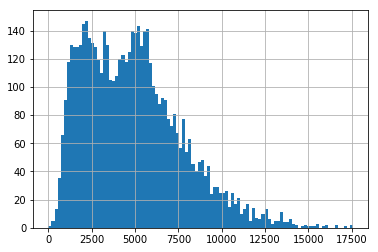

In [28]:
src['LENGHT'].hist(bins=100)

**WARNING** there are zero lenght items that should be filtered...

In [29]:
#Discarding too short and too long sounds
min_duration = 50 # in samples
max_duration = 16000
src = src[src.LENGHT>min_duration]
src = src[src.LENGHT<=max_duration]
print(f'Shortest item: {src.LENGHT.min()}')
print(f'Longest item: {src.LENGHT.max()}')
print(f'Number of items: {len(src)}')

Shortest item: 231
Longest item: 15938
Number of items: 5446


## Classify words

### Create transformations

In [30]:
#Data Augmentetion
tm = AudioTfmsManager.get_audio_tfms_manager(
                            spectro=True, #We're going to replace it...
                            mx_to_pad=max_duration, #1 sec window
                            white_noise=True, noise_scl=1e-3, # Small noise
                            modulate_volume=True, lower_gain=.95, upper_gain=1.05, # Not big volume variation
                            random_cutout=False,
                            pad_with_silence=False,
                            pitch_warp=False,
                            down_and_up=False)

In [31]:
#([functools.partial(<function tfm_add_white_noise at 0x7f45d5f849d8>, noise_scl=0.001, lower_gain=0.95, upper_gain=1.05),
#  functools.partial(<function tfm_modulate_volume at 0x7f45d5f84a60>, noise_scl=0.001, lower_gain=0.95, upper_gain=1.05),
#  functools.partial(<function tfm_pad_to_max at 0x7f45d5f84d90>, mx=16000),
#  <function __main__.tfm_multiSpectrumZoom(ad: exp.nb_AudioCommon.AudioData) -> torch.Tensor>],
# [functools.partial(<function tfm_pad_to_max at 0x7f45d5f84d90>, mx=16000),
#  <function __main__.tfm_multiSpectrumZoom(ad: exp.nb_AudioCommon.AudioData) -> torch.Tensor>])
tm.get_tfms()

[[functools.partial(<function tfm_add_white_noise at 0x7f265ee49840>, noise_scl=0.001, lower_gain=0.95, upper_gain=1.05),
  functools.partial(<function tfm_modulate_volume at 0x7f265ee498c8>, noise_scl=0.001, lower_gain=0.95, upper_gain=1.05),
  functools.partial(<function tfm_pad_to_max at 0x7f265ee49bf8>, mx=16000),
  functools.partial(<function tfm_spectro at 0x7f265ee49f28>, noise_scl=0.001, lower_gain=0.95, upper_gain=1.05)],
 [functools.partial(<function tfm_pad_to_max at 0x7f265ee49bf8>, mx=16000),
  functools.partial(<function tfm_spectro at 0x7f265ee49f28>, noise_scl=0.001, lower_gain=0.95, upper_gain=1.05)]]

In [32]:
#This is the "POST" transformation group that we're going to replace, both on train and validation... 
(tm.train_tfmsg[-1:], tm.valid_tfmsg[-1:])

([[functools.partial(<function tfm_spectro at 0x7f265ee49f28>, noise_scl=0.001, lower_gain=0.95, upper_gain=1.05)]],
 [[functools.partial(<function tfm_spectro at 0x7f265ee49f28>, noise_scl=0.001, lower_gain=0.95, upper_gain=1.05)]])

## Create multi spectrogram transformation:


In [33]:
samples = src.sample(5,random_state=1)
ads = [AudioData(src.iloc[i].SIG,src.iloc[i].SR) for i in range(len(samples))]

In [34]:
s = ads[0]
sAug = tm.try_data_augmentation(s)

#### Create multi channel transform

In [35]:
def tfm_trim(ad:AudioData, xBegin, xEnd):
    '''Extract part of original signal'''
    x = ad.sig[xBegin:xEnd]
    return AudioData(x,ad.sr)

In [36]:
tfm_trim(s,0,100).sig.shape

torch.Size([100])

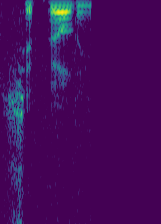

torch.Size([1, 224, 161])

In [37]:
# Scale 100%
tfm_spectro_s100 = partial(tfm_spectro,n_mels=224, ws=200, n_fft=3200, to_db_scale=True)
img = tfm_spectro_s100(sAug)
display(Image(img),img.shape) #improved

In [38]:
sAugLen = sAug.sig.shape[0]
sAugLen

16000

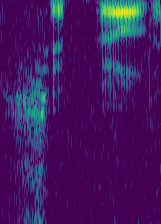

torch.Size([1, 224, 161])

In [39]:
# Scale 50%
tfm_spectro_s50 = partial(tfm_spectro,n_mels=224, ws=200//2, n_fft=3200*2, to_db_scale=True)
img = tfm_spectro_s50(tfm_trim(sAug,0,sAugLen//2))
display(Image(img),img.shape) #improved

In [40]:
sAug.sig.shape

torch.Size([16000])

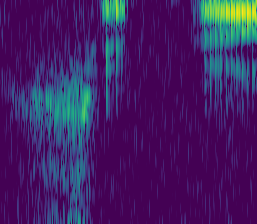

torch.Size([1, 224, 257])

In [41]:
# Scale 25%
tfm_spectro_s25 = partial(tfm_spectro,n_mels=224, ws=200//4, n_fft=3200*4, to_db_scale=True)
minLenForSpec = 6401
img = tfm_spectro_s25(tfm_trim(sAug,0,max(sAugLen//4,minLenForSpec)))
#img = img[:,:,:161] # Clamp to the size of first...
display(Image(img),img.shape) #improved

In [42]:
def tfm_multiSpectrumZoom(ad:AudioData)->torch.Tensor:
    '''This transformation is going to produce a 3-channels spectrum image from single audio data'''
    ret = None
    ret = tfm_spectro_s100(ad) # 100%
    wMax = ret.shape[2]
    
    img = tfm_spectro_s50(tfm_trim(ad,0,sAugLen//2)); img = img[:,:,:wMax] #TODO: runs in parallel...
    ret = torch.cat([ret,img],dim=0) # Stack...

    minLenForSpec = 6401 # Should be function of spectrogram parameters

    img = tfm_spectro_s25(tfm_trim(ad,0,max(sAugLen//4,minLenForSpec))); img = img[:,:,:wMax] #TODO: runs in parallel...
    ret = torch.cat([ret,img],dim=0) # Stack...

    return ret

In [43]:
%%timeit
imgMc = tfm_multiSpectrumZoom(sAug)
imgMc.shape

24.9 ms ± 207 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


**IMPORTANT**: multi spectrum transformation seems to be **VERY SLOW**...

In [44]:
# Thnx Tom @ThomM
def tfm_to_cuda(x):
    if isinstance(x,AudioData): return AudioData(x.sig.cuda(), x.sr)
    if isinstance(x,torch.Tensor): return x.cuda()
    return x    

In [45]:
sAugCuda = tfm_to_cuda(sAug)

In [46]:
%%timeit
imgMc = tfm_multiSpectrumZoom(sAugCuda)
imgMc.shape

11.3 ms ± 32.3 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


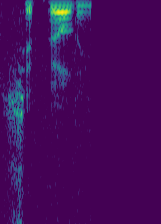

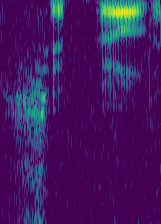

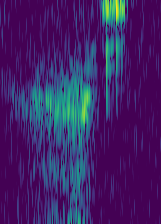

In [47]:
#Display channels inepenently
imgMc = tfm_multiSpectrumZoom(sAug)
for i in range(imgMc.shape[0]):
    display(Image(imgMc[i:i+1,:,:]))

In [48]:
tm.try_train_tfms(s)

None

tensor([[[1.0513e-04, 1.1480e-04, 8.2722e-05,  ..., 0.0000e+00,
          0.0000e+00, 0.0000e+00],
         [4.3964e-05, 2.4971e-04, 4.1012e-05,  ..., 0.0000e+00,
          0.0000e+00, 0.0000e+00],
         [1.2513e-04, 1.3981e-04, 6.6817e-05,  ..., 0.0000e+00,
          0.0000e+00, 0.0000e+00],
         ...,
         [4.3516e-05, 2.6336e-04, 1.2525e-04,  ..., 0.0000e+00,
          0.0000e+00, 0.0000e+00],
         [6.4363e-05, 2.4498e-04, 1.4917e-04,  ..., 0.0000e+00,
          0.0000e+00, 0.0000e+00],
         [6.2692e-05, 1.2928e-04, 1.2655e-04,  ..., 0.0000e+00,
          0.0000e+00, 0.0000e+00]]])

In [49]:
tm.apply_valid_tfms(s)

tensor([[[1.7241e-04, 1.0696e-04, 7.5107e-04,  ..., 0.0000e+00,
          0.0000e+00, 0.0000e+00],
         [9.8595e-05, 1.3921e-04, 4.4704e-04,  ..., 0.0000e+00,
          0.0000e+00, 0.0000e+00],
         [3.1477e-05, 3.3024e-04, 1.3801e-04,  ..., 0.0000e+00,
          0.0000e+00, 0.0000e+00],
         ...,
         [3.1624e-04, 4.3832e-04, 2.3586e-04,  ..., 0.0000e+00,
          0.0000e+00, 0.0000e+00],
         [7.6368e-05, 1.5781e-03, 8.3828e-05,  ..., 0.0000e+00,
          0.0000e+00, 0.0000e+00],
         [1.2594e-05, 6.5850e-04, 1.4622e-04,  ..., 0.0000e+00,
          0.0000e+00, 0.0000e+00]]])

### Create final transformations

We now create the final transofrmation that outputs a "multi-channel" image where channels:
 - 0: 100% signal
 - 1: 50% gignal made doubling the X resolution of spectrogram 
 - 2: 25% gignal made *4 the X resolution of spectrogram
 
The expected result on the final training is to improve classification performance on "short" sounds that are actually the most common.

**IMPORTANT**: now our output tensor is a 3-channel tensor so we can use the standard architecture
 
**TODO** : possible improvements
 - Increaze the number of zooms
 - Sliding window to cope with long signals
 - Stack multiple different transformations at one

In [50]:
#Replace the spectrogram transform with tfm_spectro_stft
tm.train_tfmsg[-1]=[tfm_multiSpectrumZoom]
tm.valid_tfmsg[-1]=[tfm_multiSpectrumZoom]
(tm.train_tfmsg[-1], tm.valid_tfmsg[-1])

([<function __main__.tfm_multiSpectrumZoom(ad: exp.nb_AudioCommon.AudioData) -> torch.Tensor>],
 [<function __main__.tfm_multiSpectrumZoom(ad: exp.nb_AudioCommon.AudioData) -> torch.Tensor>])

In [51]:
#Try single one
tm.try_train_tfms(s)

None

tensor([[[-80.0000, -80.0000, -80.0000,  ..., -80.0000, -80.0000, -80.0000],
         [-80.0000, -80.0000, -80.0000,  ..., -80.0000, -80.0000, -80.0000],
         [-80.0000, -80.0000, -80.0000,  ..., -80.0000, -80.0000, -80.0000],
         ...,
         [-80.0000, -80.0000, -80.0000,  ..., -80.0000, -80.0000, -80.0000],
         [-80.0000, -80.0000, -80.0000,  ..., -80.0000, -80.0000, -80.0000],
         [-80.0000, -77.9636, -80.0000,  ..., -80.0000, -80.0000, -80.0000]],

        [[-80.0000, -80.0000, -80.0000,  ..., -37.9702, -42.9437, -75.8948],
         [-80.0000, -80.0000, -80.0000,  ..., -36.4243, -40.6718, -80.0000],
         [-80.0000, -80.0000, -80.0000,  ..., -34.7336, -38.0320, -80.0000],
         ...,
         [-79.0218, -80.0000, -78.3888,  ..., -80.0000, -80.0000, -80.0000],
         [-79.7294, -80.0000, -76.2238,  ..., -80.0000, -80.0000, -80.0000],
         [-80.0000, -80.0000, -74.9553,  ..., -80.0000, -80.0000, -80.0000]],

        [[-80.0000, -80.0000, -79.1659,  ...

### DataBlock

In [52]:
#Create classes for all data!
classes = list(sorted(all_words_df.WRD.unique()))
len(classes), classes[:3]

(1800, ["'em", 'a', 'abbreviate'])

In [53]:
tfms = tm.get_tfms()
tfms

[[functools.partial(<function tfm_add_white_noise at 0x7f5b094859d8>, noise_scl=0.001, lower_gain=0.95, upper_gain=1.05),
  functools.partial(<function tfm_modulate_volume at 0x7f5b09485a60>, noise_scl=0.001, lower_gain=0.95, upper_gain=1.05),
  functools.partial(<function tfm_pad_to_max at 0x7f5b09485d90>, mx=16000),
  <function __main__.tfm_multiSpectrumZoom(ad: exp.nb_AudioCommon.AudioData) -> torch.Tensor>],
 [functools.partial(<function tfm_pad_to_max at 0x7f5b09485d90>, mx=16000),
  <function __main__.tfm_multiSpectrumZoom(ad: exp.nb_AudioCommon.AudioData) -> torch.Tensor>]]

In [54]:
data = (AudioList.from_df(src, path, cols=['SampleAndSr'])
        .split_from_df('is_valid')
        .label_from_df('WRD', classes=classes)
        .transform(tfms)
        .databunch(bs=64)) # NOTE: 

## Learner

In [55]:
learn = cnn_learner(data, models.resnet50, metrics=accuracy)

**No need to adapt the first layer: is actually a 3-channels image**

In [56]:
#adapt_first_layer(learn.model,nChannels)
print(f'First layer shape: {learn.model[0][0].weight.shape}')

First layer shape: torch.Size([64, 3, 7, 7])


## Train

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.32E-02


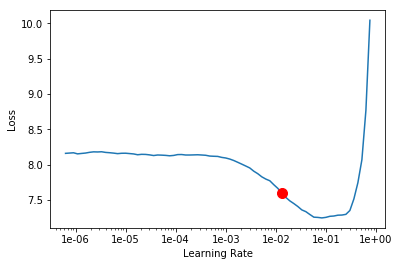

In [57]:
lr_find(learn)
learn.recorder.plot(suggestion=True)

epoch,train_loss,valid_loss,accuracy,time
0,6.385571,5.706998,0.184932,01:20
1,5.343821,5.371905,0.223288,01:19
2,4.650993,5.507854,0.234932,01:19
3,3.705725,5.718565,0.264384,01:19
4,2.645251,6.002824,0.276712,01:19
5,1.560264,5.962714,0.286986,01:19
6,0.942251,6.019049,0.304795,01:20
7,0.657904,6.026278,0.301370,01:19


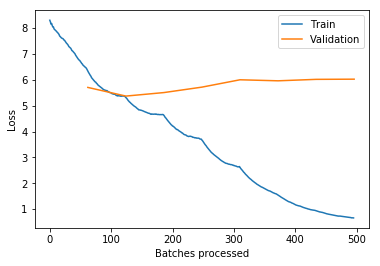

In [58]:
learn.fit_one_cycle(8, slice(1.2e-2))
learn.recorder.plot_losses()

In [59]:
learn.save('pass1_all_mc')

In [59]:
learn.freeze_to(1)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 8.32E-06


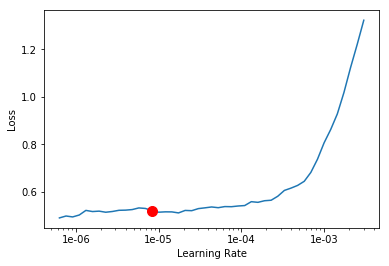

In [60]:
lr_find(learn)
learn.recorder.plot(suggestion=True)

epoch,train_loss,valid_loss,accuracy,time
0,0.524080,6.047255,0.304110,01:20
1,0.533861,6.033799,0.299315,01:19
2,0.492218,5.951017,0.304795,01:20
3,0.445815,5.983784,0.307534,01:20
4,0.406293,5.969075,0.307534,01:19
5,0.377268,5.934899,0.313014,01:20
6,0.343357,5.951553,0.311644,01:20
7,0.325536,5.941833,0.308904,01:20


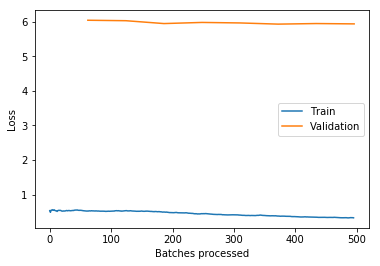

In [61]:
learn.fit_one_cycle(8, slice(1e-4))
learn.recorder.plot_losses()

In [63]:
learn.save('pass2_all')

In [62]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.58E-06


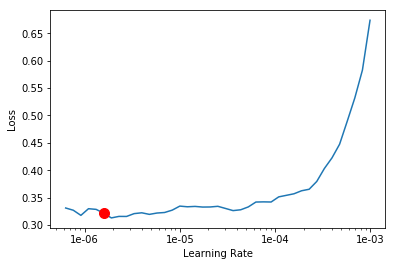

In [63]:
lr_find(learn)
learn.recorder.plot(suggestion=True)

epoch,train_loss,valid_loss,accuracy,time
0,0.315588,5.934622,0.310959,01:20
1,0.314943,5.922575,0.310959,01:20
2,0.325263,5.942605,0.308904,01:20
3,0.311082,5.910153,0.313014,01:20
4,0.301132,5.894815,0.313014,01:20
5,0.286729,5.904769,0.313699,01:20
6,0.286385,5.898260,0.310274,01:20
7,0.286107,5.893535,0.309589,01:20


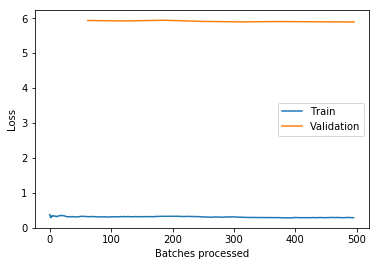

In [64]:
learn.fit_one_cycle(8, slice(1e-6, 1.1e-5))
learn.recorder.plot_losses()

In [67]:
learn.save('pass3_all')

Not so good result: should work on it ;-)

In [73]:
a = s.sig.unsqueeze(0).unsqueeze(0)
a.shape, a.permute(2,0,1).shape

(torch.Size([1, 1, 9080]), torch.Size([9080, 1, 1]))

## Fin.